# Section 4: Deep Learning
## Project: Male vs Female Eye Classification
- Dataset: https://www.kaggle.com/pavelbiz/eyes-rtte

### 개요
여성과 남성의 눈은 그 형태는 매우 비슷하지만 분명 구분되는 특징이 존재한다.   
눈만 나타난 사진을 보고 성별을 구분하는 것은 사람에게는 쉽지만 컴퓨터에게는 어려운 일이다.   
인공 신경망을 이용하여 눈 이미지를 성별에 맞게 분류해보자.   

### 응용분야
얼굴 인식, 보안(페이스 아이디)

---

## 목차:
0. 랜덤 시드 고정
1. 데이터셋 준비
2. 데이터 불러오기 및 시각화
3. 모델 만들기 및 학습
- ANN
- CNN
- MobileNet
4. 테스트
5. 결론

## Imports

In [1]:
import numpy as np
import tensorflow as tf

import os
import shutil
import random
import glob

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D

## 0. 랜덤 시드 고정 (Optional)

In [2]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

## 1. 데이터셋 준비
- 데이터셋을 다운로드하여 압축을 풀면 하위폴더로 `/femaleyes`와 `/maleeyes`라는 폴더가 나온다.
- 각 폴더안에는 여성과 남성의 눈 이미지가 각각 5~6천개 정도 들어있다.
- 이 데이터를 밸런스를 맞추어 train, val, test 세트로 폴더를 나누고 이동한다.

In [3]:
dir('data/dogs/ os.path.isdir('train/dog') femaleFalse:
    o
    sprint('creating datasets...').makedirs('train/dog')
 femaleos.makedirs('train/cat')
  males.makedirs('valid/dog')
   female.makedirs('valid/cat')
    malemakedirs('test/dog')
    ofemaleakedirs('test/cat')

    fmalei in random.sample(glob.glob('cat*'), 500):
femaleeyes/     3500til.move(i, 'train/cat')      
   femaler i in random.sample(glob.glob('dog*'), 500):
  maleeyes/*  sh35til.move(i, 'train/dog')
    for i imaleandom.sample(glob.glob('cat*'), 100):
    femaleeyes/*shutil0.move(i, 'valid/cat')        
    ffemalei in random.sample(glob.glob('dog*'), 100):
      maleeyes/*util.m0ove(i, 'valid/dog')
    for i in ramalem.sample(glob.glob('cat*'), 50):
        sfemaleeyes/*l.move0(i, 'test/cat')      
    for i ifemaleandom.sample(glob.glob('dog*'), 50):
        shumaleeyes/*move(i0, 'test/dog')

os.chdir('../../')male
    else:
    print()'dataset already exists! skipping...'

dataset already exists! skipping...


## 2. 데이터 불러오기 및 시각화
- 정돈한 데이터를 학습에 사용할 수 있게 알맞은 형태(`Sequence`)로 불러옵니다.
- 불러온 데이터를 `plot`하여 레이블과 함께 확인합니다.

In [4]:
train_path = 'data/train'
valid_path = 'data/valid'
test_path = 'data/test'

In [5]:
train_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=train_path, target_size=(224, 224))
valid_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=valid_path, target_size=(224, 224))
test_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=test_path, target_size=(224, 224), shuffle=False)

Found 7000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
imgs, labels = next(train_batches)

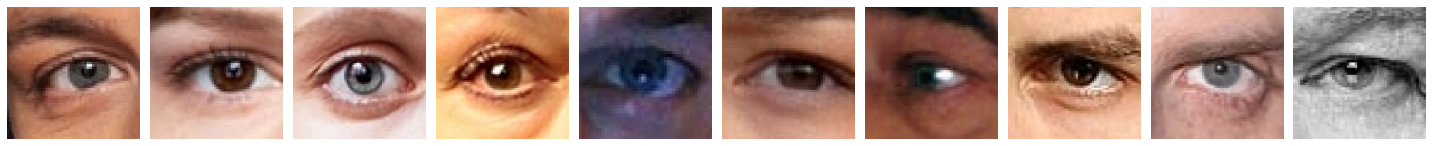

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [7]:
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr[:10], axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_images(imgs)
print(labels[:10])

In [8]:
imgs[0].shape

(224, 224, 3)

## 3-1. 기본 인공 신경망 모델 (ANN)

In [9]:
model_1 = Sequential([
    Flatten(input_shape=(224, 224, 3)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                9633856   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 9,638,146
Trainable params: 9,638,146
Non-trainable params: 0
_________________________________________________________________


In [10]:
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
history_1 = model_1.fit(
    x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=10,
    verbose=1
)

Epoch 1/10
219/219 [==============================] - 10s 46ms/step - loss: 3.1068 - accuracy: 0.6509 - val_loss: 0.6798 - val_accuracy: 0.7580
Epoch 2/10
219/219 [==============================] - 9s 43ms/step - loss: 1.1436 - accuracy: 0.6910 - val_loss: 0.6109 - val_accuracy: 0.7585
Epoch 3/10
219/219 [==============================] - 10s 44ms/step - loss: 0.5833 - accuracy: 0.7526 - val_loss: 0.4094 - val_accuracy: 0.8165
Epoch 4/10
219/219 [==============================] - 10s 43ms/step - loss: 0.4711 - accuracy: 0.7900 - val_loss: 0.3971 - val_accuracy: 0.8205
Epoch 5/10
219/219 [==============================] - 10s 47ms/step - loss: 0.4119 - accuracy: 0.8220 - val_loss: 0.5626 - val_accuracy: 0.7475
Epoch 6/10
219/219 [==============================] - 10s 47ms/step - loss: 0.4571 - accuracy: 0.7980 - val_loss: 0.3984 - val_accuracy: 0.8265
Epoch 7/10
219/219 [==============================] - 10s 47ms/step - loss: 0.4610 - accuracy: 0.7930 - val_loss: 0.4241 - val_accuracy: 

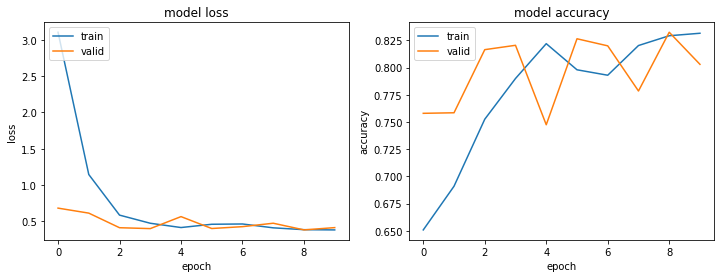

In [12]:
def plot_history(history):
    plt.rcParams["figure.figsize"] = (12,4)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

plot_history(history_1)

## 3-2. 합성곱 신경망 모델 (CNN)

In [13]:
model_2 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
________________________________________________

In [14]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
history_2 = model_2.fit(
    x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=10,
    verbose=1
)

Epoch 1/10
219/219 [==============================] - 113s 515ms/step - loss: 0.5748 - accuracy: 0.7457 - val_loss: 0.5390 - val_accuracy: 0.7580
Epoch 2/10
219/219 [==============================] - 107s 490ms/step - loss: 0.3963 - accuracy: 0.8264 - val_loss: 0.4297 - val_accuracy: 0.8195
Epoch 3/10
219/219 [==============================] - 104s 476ms/step - loss: 0.3365 - accuracy: 0.8601 - val_loss: 0.3463 - val_accuracy: 0.8435
Epoch 4/10
219/219 [==============================] - 104s 473ms/step - loss: 0.3207 - accuracy: 0.8647 - val_loss: 0.3328 - val_accuracy: 0.8515
Epoch 5/10
219/219 [==============================] - 102s 465ms/step - loss: 0.3021 - accuracy: 0.8754 - val_loss: 0.3382 - val_accuracy: 0.8640
Epoch 6/10
219/219 [==============================] - 103s 469ms/step - loss: 0.2647 - accuracy: 0.8909 - val_loss: 0.4336 - val_accuracy: 0.8335
Epoch 7/10
219/219 [==============================] - 102s 468ms/step - loss: 0.2541 - accuracy: 0.8960 - val_loss: 0.3501 -

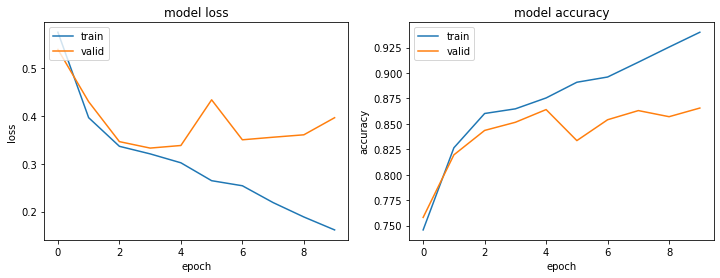

In [16]:
plot_history(history_2)

## 3-3. 외부모델을 전이학습 (MobileNet)

In [17]:
mobile = tf.keras.applications.mobilenet.MobileNet()
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [18]:
x = mobile.layers[-6].output
output = Dense(units=2, activation='softmax')(x)

model_3 = Model(inputs=mobile.input, outputs=output)

for layer in model_3.layers[:-23]:
    layer.trainable = False

model_3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [19]:
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
history_3 = model_3.fit(
    x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=10,
    verbose=1
)

Epoch 1/10
219/219 [==============================] - 122s 554ms/step - loss: 0.2401 - accuracy: 0.9117 - val_loss: 0.3681 - val_accuracy: 0.8800
Epoch 2/10
219/219 [==============================] - 120s 549ms/step - loss: 0.0965 - accuracy: 0.9609 - val_loss: 0.2072 - val_accuracy: 0.9150
Epoch 3/10
219/219 [==============================] - 118s 538ms/step - loss: 0.0829 - accuracy: 0.9676 - val_loss: 0.2245 - val_accuracy: 0.9230
Epoch 4/10
219/219 [==============================] - 117s 535ms/step - loss: 0.0684 - accuracy: 0.9761 - val_loss: 0.2627 - val_accuracy: 0.9175
Epoch 5/10
219/219 [==============================] - 120s 546ms/step - loss: 0.0502 - accuracy: 0.9816 - val_loss: 0.3573 - val_accuracy: 0.9010
Epoch 6/10
219/219 [==============================] - 131s 601ms/step - loss: 0.0367 - accuracy: 0.9863 - val_loss: 0.2146 - val_accuracy: 0.9325
Epoch 7/10
219/219 [==============================] - 127s 578ms/step - loss: 0.0315 - accuracy: 0.9883 - val_loss: 0.1479 -

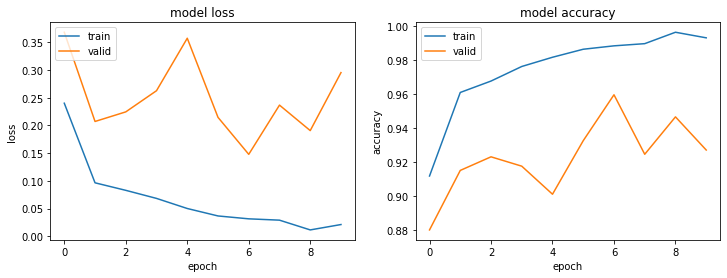

In [21]:
plot_history(history_3)

## 4. 테스트셋 비교

In [22]:
result_1 = model_1.evaluate(test_batches)

32/32 [==============================] - 1s 26ms/step - loss: 0.3510 - accuracy: 0.8410


In [23]:
result_2 = model_2.evaluate(test_batches)

32/32 [==============================] - 4s 131ms/step - loss: 0.3330 - accuracy: 0.8760


In [24]:
result_3 = model_3.evaluate(test_batches)

32/32 [==============================] - 9s 293ms/step - loss: 0.2752 - accuracy: 0.9370


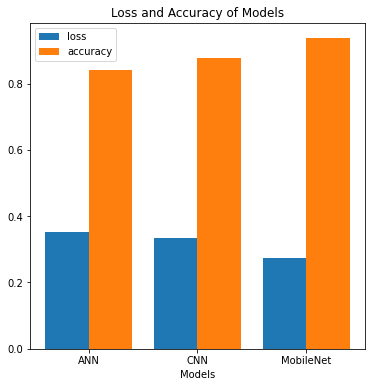

In [25]:
plt.rcParams["figure.figsize"] = (6,6)
X = ['ANN', 'CNN', 'MobileNet']
loss = [result[0] for result in (result_1, result_2, result_3)]
acc = [result[1] for result in (result_1, result_2, result_3)]
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, loss, 0.4, label = 'loss')
plt.bar(X_axis + 0.2, acc, 0.4, label = 'accuracy')
  
plt.xticks(X_axis, X)
plt.xlabel("Models")
plt.title("Loss and Accuracy of Models")
plt.legend()
plt.show()

## 5. 결론
### 기본적인 ANN만으로도 약 80%의 정확도를 달성할 수 있었다. 학습시간 대비 좋은 성능을 낼 수 있지만 아무리 학습을 많이 하더라도 성능에 한계가 있었다.
### CNN을 도입하자 성능이 더욱 좋아졌다. 다만 에폭당 학습시간이 열배 넘게 증가했다.
### MobileNet은 훈련데이터에서 10 에포크시 99%의 정확도를 보였고 검증 및 테스트 정확도에서도 다른 모델보다 높은 성능을 보였다.
### 세 모델 모두 훈련과 검증/테스트 간의 정확도 차가 다소 크기 때문에 일반화가 덜 된 것으로 보인다. 추후 파라미터 조정을 통해 좀 더 성능을 극대화해볼 수 있겠다.